# Unitary overlap cost function gradient descent

Created 23/10/2024

Objectives:
* Apply gradient descent algorithm to an MPO along with overlap gradient to see if we can get a decent solution.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [4]:
from functools import reduce

In [556]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt

In [6]:
import re

In [7]:
from SPTOptimization.utils import (
    get_right_identity_environment_from_tp_tensor,
    to_npc_array
)

from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

# Load data

In [8]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [9]:
f_name = DATA_DIR + r"/0_00.h5"

In [10]:
f_name

'../../data/transverse_cluster_200_site_dmrg/0_00.h5'

In [11]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitons

In [12]:
NUM_SITES=5
BOND_DIMENSION=4
PHYSICAL_DIMENSION=2
LEARNING_RATE = 0.01

In [13]:
total_dimension = PHYSICAL_DIMENSION**NUM_SITES

In [14]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [15]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

In [16]:
def generate_random_w_tensor(dims):
    x1 = np.random.rand(*dims)
    x2 = 1j*np.random.rand(*dims)

    return x1 + x2

In [17]:
edge_dims = [PHYSICAL_DIMENSION,]*2 + [BOND_DIMENSION,]
inner_dims = edge_dims + [BOND_DIMENSION,]

In [18]:
w = generate_random_w_tensor(edge_dims)

In [19]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vR'])

In [20]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>

In [21]:
w_tensors = [w_tensor,]

In [22]:
for _ in range(NUM_SITES-2):
    w = generate_random_w_tensor(inner_dims)
    w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
    
    w_tensors.append(w_tensor)

In [23]:
w = generate_random_w_tensor(edge_dims)

In [24]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL'])

In [25]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>

In [26]:
w_tensors.append(w_tensor)

In [27]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

## Test symmetry case

In [28]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [29]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [30]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [31]:
test_case = SymmetryActionWithBoundaryUnitaries(
    test_psi,
    symmetry_actions[1]*50,
    left_boundary_unitaries=[np_I,]*3,
    right_boundary_unitaries=[np_I,]*3
)

In [32]:
test_case.compute_svd_approximate_expectation()

(-6.371358002176382e-29+0j)

## Functions

In [33]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [34]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t

In [35]:
def unitary_order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [36]:
def unitary_order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [37]:
w_tensors[-1].conj()

<npc.Array shape=(2, 2, 4) labels=['p*', 'p', 'vL*']>

In [38]:
def overlap_right_tensors(w_tensors, b_tensors):
    out = list()

    t = get_right_identity_environment_from_tp_tensor(b_tensors[-1])

    out.append(t)

    b = b_tensors[-1]
    w = w_tensors[-1]
    
    t = npc.tensordot(t, b, [['vL',], ['vR',]])
    t = npc.tensordot(
        t,
        w.conj().replace_label('vL*', 'vLm'),
        [['p',], ['p*',]]
    )
    t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])

    out.append(t)

    for w, b in zip(w_tensors[-2:0:-1], b_tensors[-2:0:-1]):
        t = npc.tensordot(t, b, [['vL',], ['vR',]])
        t = npc.tensordot(
            t,
            w.conj().replace_label('vL*', 'vLm'),
            [['p', 'vLm'], ['p*', 'vR*']]
        )
        t = npc.tensordot(t, b.conj(), [['p', 'vL*',], ['p*', 'vR*',]])
    
        out.append(t)

    return out[::-1]

### Initialize tensors

In [39]:
def rescale_mpo_tensors(mpo_tensors, new_norm):
    num_sites = len(mpo_tensors)

    old_norm = mpo_frobenius_inner_product(mpo_tensors).real
    
    scale_factor = np.power(
        new_norm/old_norm,
        1/(2*num_sites)
    )

    for i in range(num_sites):
        mpo_tensors[i] = scale_factor*mpo_tensors[i]

In [572]:
def generate_random_w_tensor(physical_dim, left_virtual_dim=None,
                             right_virtual_dim=None):

    if (left_virtual_dim is None) and (right_virtual_dim is None):
        dims = (physical_dim, physical_dim)
    elif (left_virtual_dim is None):
        dims = (physical_dim, physical_dim, right_virtual_dim)
    elif (right_virtual_dim is None):
        dims = (physical_dim, physical_dim, left_virtual_dim)
    else: 
        dims = (
            physical_dim,
            physical_dim,
            left_virtual_dim,
            right_virtual_dim
        )
    
    X1 = rng.normal(size=dims)
    X2 = 1j*rng.normal(size=dims)
    X = X1 + X2

        
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*'])
    elif right_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vL'])
    elif left_virtual_dim is None:
        out = npc.Array.from_ndarray_trivial(X, labels=['p', 'p*', 'vR'])
    else:
        out = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return out

In [40]:
def get_random_mpo_tensors(num_sites, norm=None):
    """
    Needs more arguments
    """

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vR']
    )

    w_tensors = [w_tensor,]

    for _ in range(num_sites-2):
        w = generate_random_w_tensor(inner_dims)
        w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
        
        w_tensors.append(w_tensor)

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vL']
    )
    w_tensors.append(w_tensor)

    if norm is not None:
        rescale_mpo_tensors(w_tensors, norm)

    return w_tensors

In [41]:
def get_identity_w_tensor(physical_dim, left_virtual_dim=None, right_virtual_dim=None):
    diagonal = np.ones(physical_dim, dtype='complex')
    identity_matrix = np.diag(diagonal)
    
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        w_tensor = npc.Array.from_ndarray_trivial(
            identity_matrix,
            labels=['p', 'p*']
        )
    elif right_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL']
        )
    elif left_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vR']
        )
    else:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return w_tensor

In [196]:
def get_random_mpo_tensors(physical_dims, virtual_dims):
    """
    Could fold in with get_identity_mpo_tensors
    """

    w_tensors = [
        generate_random_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

In [42]:
def get_identity_mpo_tensors(physical_dims, virtual_dims):
    """
    Needs more comments, docs!

    Often physical dims, virtual dims will be the same, so could add
    optional behaviour...
    """

    w_tensors = [
        get_identity_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

### Sweep function

In [43]:
def mpo_tensor_raw_to_gradient(raw_mpo_tensor, gradient_target_tensor):
    """
    Update raw_mpo_tensor calculated to be the gradient by changing leg names
    as neeeded so can be easily and consistently added to
    gradient_target_tensor.
    """
    leg_labels = raw_mpo_tensor.get_leg_labels()

    # First update the virtual legs
    old_new_leg_label_pairs = [
        ('vL*', 'vR'),
        ('vR*', 'vL'),
        ('vL1*', 'vR'),
        ('vR1*', 'vL'),
        ('vLm', 'vR'),
        ('vRm', 'vL'),
    ]

    for old, new in old_new_leg_label_pairs:
        if old in leg_labels:
            raw_mpo_tensor.ireplace_label(old, new)

    # Then create new array to get the physical legs correct.
    # Is this consistent? Should set order of leg labels on raw_mpo_tensor
    # before casting to array?
    out = npc.Array.from_ndarray_trivial(
        raw_mpo_tensor.to_ndarray(),
        labels=raw_mpo_tensor.get_leg_labels()
    )

    out.itranspose(gradient_target_tensor.get_leg_labels())

    return out

In [44]:
def update_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                     score_list,
                     virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]],
                     take_abs=False
                    ):
    # Calculate "score" (just the contraction of the two relevant tensors)
    # and add to score_list
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    )

    if take_abs:
        real_score = np.abs(score)
    else:
        real_score = score.real

    score_list.append(real_score)

    return score

In [45]:
def mpo_gradient_descent_sweep(mpo_tensors, b_tensors,
    unitarity_learning_rate, overlap_learning_rate, matrix_dim,
    overlap_target, left_environment):
    """
    Really need to tidy this function up...

    Also get matrix_dim directly from tensors.
    """

    # Initialise variables
    right_unitary_two_tensors = unitary_order_two_right_tensors(mpo_tensors)
    right_unitary_four_tensors = unitary_order_four_right_tensors(mpo_tensors)
    right_overlap_tensors = overlap_right_tensors(mpo_tensors, b_tensors)
    
    left_unitary_two_tensors = list()
    left_unitary_four_tensors = list()
    left_overlap_tensors = list()

    unitary_order_two_scores = list()
    unitary_order_four_scores = list()
    overlap_scores = list()

    num_sites = len(mpo_tensors)
    assert len(mpo_tensors) == len(b_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    b = b_tensors[0]

    t = right_unitary_two_tensors[0]

    # Second order terms
    grad_2 = npc.tensordot(t, w, [['vL'], ['vR',]])

    update_mpo_score(grad_2, w, unitary_order_two_scores, [['vL*',], ['vR*',]])

    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    # Fourth order terms
    t = right_unitary_four_tensors[0]

    grad_4 = npc.tensordot(t, w, [['vL'], ['vR',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vL1', 'p'], ['vR', 'p*']])

    update_mpo_score(grad_4, w, unitary_order_four_scores, [['vL1*',], ['vR*',]])

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    # Overlap terms
    t = right_overlap_tensors[0]

    grad_o = npc.tensordot(t, b, [['vL'], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(grad_o, left_environment, [['vL', 'vL*'], ['vR', 'vR*']])

    c_conj = update_mpo_score(
        grad_o,
        w,
        overlap_scores,
        [['vLm',], ['vR*',]],
        take_abs=True
    )
    c = c_conj.conjugate()
    c_abs = np.abs(c)
    
    grad_o_scale = c*(1 - overlap_target/c_abs)
    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

    # Update tensor
    mpo_tensors[0] = (
        w
        - unitarity_learning_rate*(grad_4 - grad_2) 
        - overlap_learning_rate*grad_o
    )

    # Create and save left tensors
    w = mpo_tensors[0]

    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_unitary_two_tensors.append(t)
    
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    left_unitary_four_tensors.append(t)

    t = npc.tensordot(b, w.conj(), [['p',], ['p*',]])
    #print(t)
    t.ireplace_label('vR*', 'vRm')
    #print(t)
    t = npc.tensordot(t, left_environment, [['vL',], ['vR',]])
    #print(t)
    t = npc.tensordot(t, b.conj(), [['vR*', 'p'], ['vL*', 'p*']])

    #print(t)

    left_overlap_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w = mpo_tensors[i]
        b = b_tensors[i]
    
        right_two_tensor = right_unitary_two_tensors[i]
        right_four_tensor = right_unitary_four_tensors[i]
        right_overlap_tensor = right_overlap_tensors[i]

        # Order two terms
        left_two_tensor = left_unitary_two_tensors[-1]

        grad_2 = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_2 = npc.tensordot(grad_2, left_two_tensor, [['vL'], ['vR',]])

        update_mpo_score(grad_2, w, unitary_order_two_scores)
        grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

        # Order four terms
        left_four_tensor = left_unitary_four_tensors[-1]

        grad_4 = npc.tensordot(right_four_tensor, w, [['vL'], ['vR',]])
        grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        grad_4 = npc.tensordot(
            grad_4,
            w.replace_label('vL', 'vL1'),
            [['vL1', 'p'], ['vR', 'p*']]
        )

        grad_4 = npc.tensordot(
            grad_4,
            left_four_tensor,
            [['vL', 'vL*', 'vL1'], ['vR', 'vR*', 'vR1']]
        )

        update_mpo_score(
            grad_4,
            w,
            unitary_order_four_scores,
            [['vL1*', 'vR1*',], ['vR*', 'vL*',]]
        )
        grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

        # Overlap terms
        left_overlap_tensor = left_overlap_tensors[-1]

        grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
        grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
        grad_o = npc.tensordot(
            grad_o,
            left_overlap_tensor,
            [['vL*', 'vL'], ['vR', 'vR*',]]
        )
        
        c_conj = update_mpo_score(
            grad_o,
            w,
            overlap_scores,
            [['vLm', 'vRm'], ['vR*', 'vL*']],
            take_abs=True
        )
        c = c_conj.conjugate()
        c_abs = np.abs(c)
        
        grad_o_scale = c*(1 - overlap_target/c_abs)
        grad_o = grad_o_scale*grad_o
        grad_o = mpo_tensor_raw_to_gradient(grad_o, w)

        mpo_tensors[i] = (
            w
            - unitarity_learning_rate*(grad_4 - grad_2) 
            - overlap_learning_rate*grad_o
        )

        w = mpo_tensors[i]

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_unitary_two_tensors.append(t)
        
        t = npc.tensordot(left_four_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(t, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vR1'),
            [['p', 'vR1'], ['p*', 'vL']]
        )
        t = npc.tensordot(
            t,
            w.conj().replace_label('vR*', 'vR1*'),
            [['p', 'p*', 'vR1*'], ['p*', 'p', 'vL*']]
        )
        
        left_unitary_four_tensors.append(t)

        t = left_overlap_tensor.ireplace_label('vR*', 'vR1*')
        t = npc.tensordot(
            left_overlap_tensor,
            w.conj(),
            [['vRm',], ['vL*']]
        )
        t.ireplace_label('vR*', 'vRm')
        t = npc.tensordot(t, b, [['vR', 'p*'], ['vL', 'p']])
        t = npc.tensordot(t, b.conj(), [['vR1*', 'p'], ['vL*', 'p*']])

        left_overlap_tensors.append(t)

    # Last site
    left_two_tensor = left_unitary_two_tensors[-1]
    w = mpo_tensors[-1]
    b = b_tensors[-1]
    
    grad_2 = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    
    update_mpo_score(grad_2, w, unitary_order_two_scores, [['vR*',], ['vL*',]])
    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    left_four_tensor = left_unitary_four_tensors[-1]
    
    grad_4 = npc.tensordot(left_four_tensor, w, [['vR'], ['vL',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vR1', 'p'], ['vL', 'p*']])
    
    update_mpo_score(grad_4, w, unitary_order_four_scores, [['vR1*',], ['vL*',]])
    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    left_overlap_tensor = left_overlap_tensors[-1]
    right_overlap_tensor = right_overlap_tensors[-1]

    grad_o = npc.tensordot(right_overlap_tensor, b, [['vL',], ['vR',]])
    grad_o = npc.tensordot(grad_o, b.conj(), [['vL*',], ['vR*',]])
    grad_o = npc.tensordot(
        grad_o,
        left_overlap_tensor,
        [['vL*', 'vL'], ['vR', 'vR*',]]
    )
    
    c_conj = update_mpo_score(
        grad_o,
        w,
        overlap_scores,
        [['vRm',], ['vL*',]],
        take_abs=True
    )
    c = c_conj.conjugate()
    c_abs = np.abs(c)
    
    grad_o_scale = c*(1 - overlap_target/c_abs)
    grad_o = grad_o_scale*grad_o
    grad_o = mpo_tensor_raw_to_gradient(grad_o, w)
    
    mpo_tensors[-1] = (
        w
        - unitarity_learning_rate*(grad_4 - grad_2) 
        - overlap_learning_rate*grad_o
    )

    # To-do: Calculate total errors here.

    unitary_order_two_scores = np.array(unitary_order_two_scores)
    unitary_order_four_scores = np.array(unitary_order_four_scores)
    overlap_scores = np.array(overlap_scores)

    unitary_scores = (
        unitary_order_four_scores
        - 2*unitary_order_two_scores
        + matrix_dim
    )

    overlap_target_scores = (overlap_scores - overlap_target)**2
    
    cost_function_scores = (
        (unitarity_learning_rate/4.0)*unitary_scores
        + (overlap_learning_rate/2.0)*overlap_target_scores
    )

    return (
        unitary_order_two_scores,
        unitary_order_four_scores,
        unitary_scores,
        overlap_scores,
        overlap_target_scores,
        cost_function_scores
    )

In [46]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [47]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

# Test

## Solution test

In [136]:
num_sites = 2

In [137]:
total_dimension = 2**num_sites

In [138]:
num_iterations = 500

In [139]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 1),] + [(1, None),]

In [140]:
X_1 = np.array([[[1,0],[0,-1]]])

In [147]:
X_1.shape

(1, 2, 2)

In [148]:
w_1 = npc.Array.from_ndarray_trivial(X_1, labels=['vR', 'p', 'p*'])

In [149]:
w_2 = get_identity_w_tensor(2, left_virtual_dim=1)

In [150]:
w_tensors = [w_1, w_2]

In [152]:
mpo_frobenius_inner_product(w_tensors)

(4+0j)

In [153]:
total_dimension

4

In [154]:
w_tensors

[<npc.Array shape=(1, 2, 2) labels=['vR', 'p', 'p*']>,
 <npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vL']>]

In [155]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [156]:
b_tensors

[<npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>]

In [158]:
unitarity_learning_rate = 1e-3
overlap_learning_rate = 1e-3

In [159]:
overlap_right_tensors(w_tensors, b_tensors)

[<npc.Array shape=(2, 1, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 2) labels=['vL', 'vL*']>]

In [160]:
unitary_order_two_scores = list()
unitary_order_four_scores = list()
unitary_scores = list()
overlap_scores = list()
overlap_target_scores = list()
cost_function_scores = list()

In [161]:
for _ in range(num_iterations):
    out = mpo_gradient_descent_sweep(
        w_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        total_dimension,
        np.sqrt(2),
        test_case.right_projected_symmetry_state
    )
    
    unitary_order_two_scores.append(out[0])
    unitary_order_four_scores.append(out[1])
    unitary_scores.append(out[2])
    overlap_scores.append(out[3])
    overlap_target_scores.append(out[4])
    cost_function_scores.append(out[5])

In [162]:
unitary_scores_array = np.array(unitary_scores)

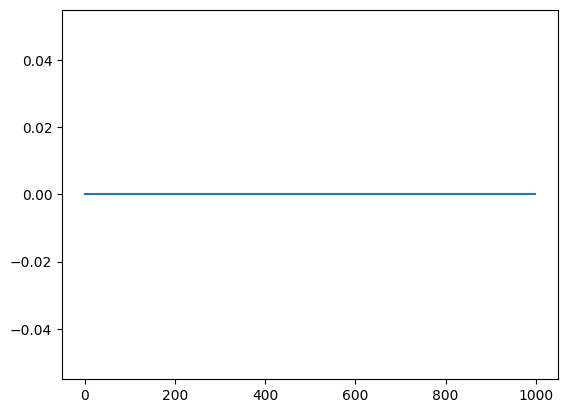

In [163]:
plt.plot(unitary_scores_array.flatten())

In [164]:
unitary_scores_array[-1]

array([0., 0.])

In [165]:
unitary_order_two_scores_array = np.array(unitary_order_two_scores)

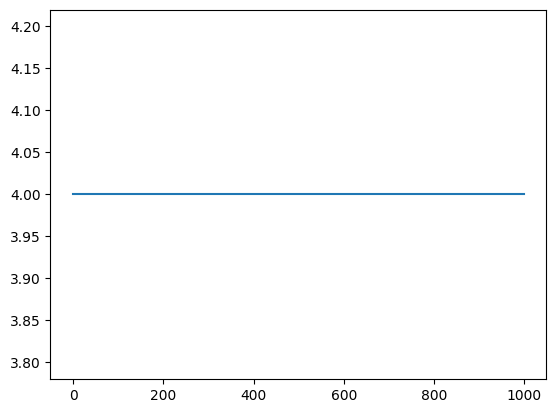

In [166]:
plt.plot(unitary_order_two_scores_array.flatten())

In [167]:
unitary_order_four_scores_array = np.array(unitary_order_four_scores)

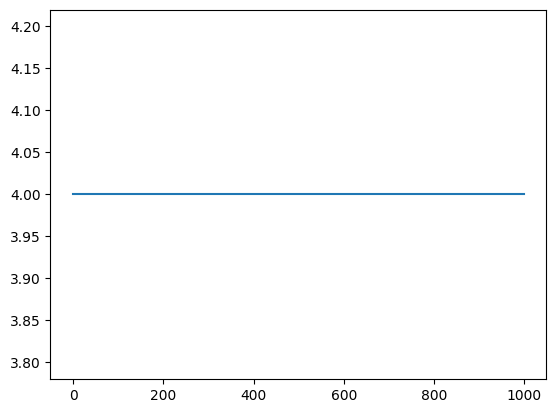

In [168]:
plt.plot(unitary_order_four_scores_array.flatten())

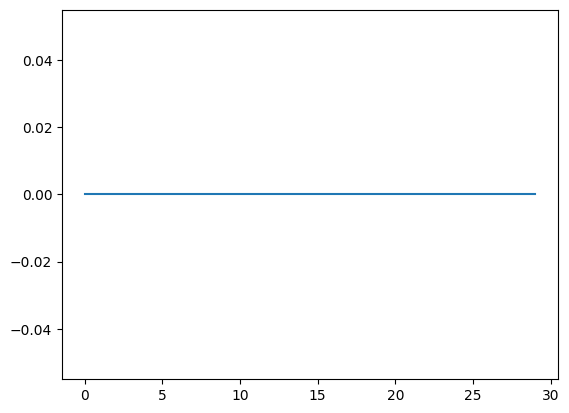

In [169]:
plt.plot(unitary_scores_array.flatten()[:30])

In [170]:
unitary_scores_array[-1]

array([0., 0.])

In [171]:
overlap_scores_array = np.array(overlap_scores)

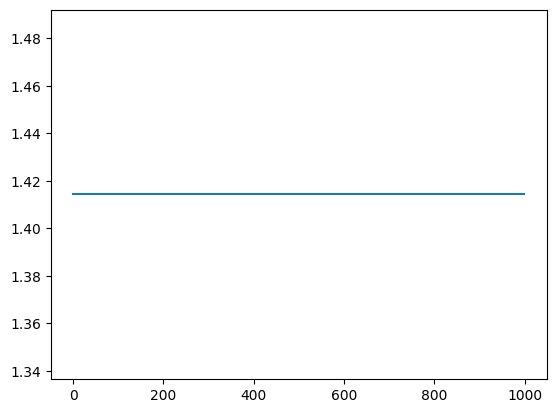

In [172]:
plt.plot(overlap_scores_array.flatten())

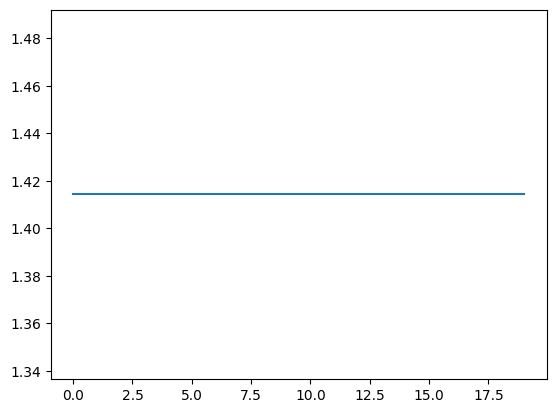

In [173]:
plt.plot(overlap_scores_array.flatten()[:20])

In [174]:
overlap_target_scores_array = np.array(overlap_target_scores)

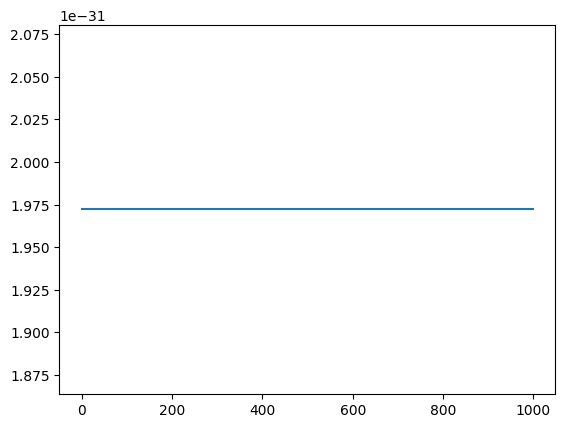

In [175]:
plt.plot(overlap_target_scores_array.flatten())

In [180]:
overlap_target_scores_array[-1]

array([1.97215226e-31, 1.97215226e-31])

In [176]:
cost_scores_array = np.array(cost_function_scores)

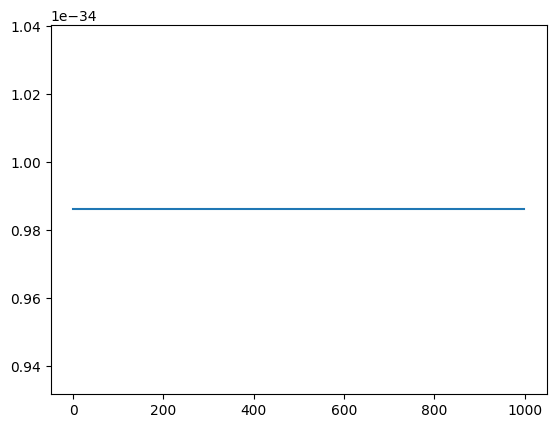

In [177]:
plt.plot(cost_scores_array.flatten())

In [178]:
cost_scores_array[-1]

array([9.86076132e-35, 9.86076132e-35])

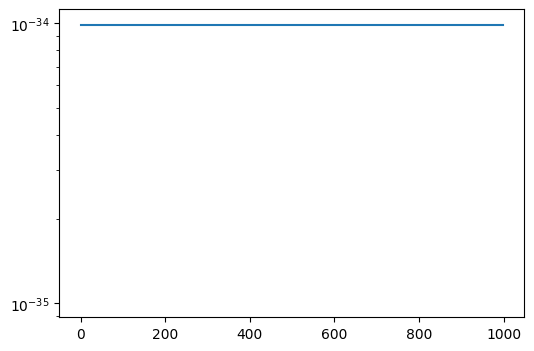

In [179]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(cost_scores_array.flatten())

ax.set_yscale('log')

## Perturbed Solution test

In [573]:
num_sites = 2

In [574]:
total_dimension = 2**num_sites

In [575]:
num_iterations = 500

In [576]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 1),] + [(1, None),]

In [577]:
X_1 = np.array([[[1,],[0,]],[[0,],[-1,]]])

In [578]:
X_1.shape

(2, 2, 1)

In [579]:
w_1 = npc.Array.from_ndarray_trivial(X_1, labels=['p', 'p*', 'vR'])

In [580]:
w_2 = get_identity_w_tensor(2, left_virtual_dim=1)

In [581]:
sol_w_tensors = [w_1, w_2]

In [582]:
perturbations = get_random_mpo_tensors(physical_dims, virtual_dims)

In [583]:
w_1

<npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vR']>

In [584]:
w_2

<npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vL']>

In [585]:
perturbations

[<npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vL']>]

In [586]:
w_tensors = [
    w1 + 0.05*w2
    for w1, w2 in zip(sol_w_tensors, perturbations)
]

In [587]:
mpo_frobenius_inner_product(w_tensors)

(3.6492840445477674+3.0057090204711334e-18j)

In [588]:
total_dimension

4

In [589]:
w_tensors

[<npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vL']>]

In [590]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [591]:
b_tensors

[<npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>]

In [592]:
unitarity_learning_rate = 1e-2
overlap_learning_rate = 1e-2

In [593]:
overlap_right_tensors(w_tensors, b_tensors)

[<npc.Array shape=(2, 1, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 2) labels=['vL', 'vL*']>]

In [594]:
unitary_order_two_scores = list()
unitary_order_four_scores = list()
unitary_scores = list()
overlap_scores = list()
overlap_target_scores = list()
cost_function_scores = list()

In [595]:
for _ in range(num_iterations):
    out = mpo_gradient_descent_sweep(
        w_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        total_dimension,
        np.sqrt(2),
        test_case.right_projected_symmetry_state
    )
    
    unitary_order_two_scores.append(out[0])
    unitary_order_four_scores.append(out[1])
    unitary_scores.append(out[2])
    overlap_scores.append(out[3])
    overlap_target_scores.append(out[4])
    cost_function_scores.append(out[5])

In [596]:
unitary_scores_array = np.array(unitary_scores)

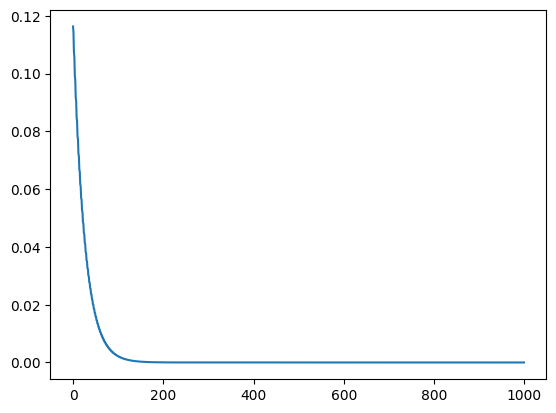

In [597]:
plt.plot(unitary_scores_array.flatten())

In [598]:
unitary_scores_array[-1]

array([1.14235837e-06, 1.14233377e-06])

In [599]:
unitary_order_two_scores_array = np.array(unitary_order_two_scores)

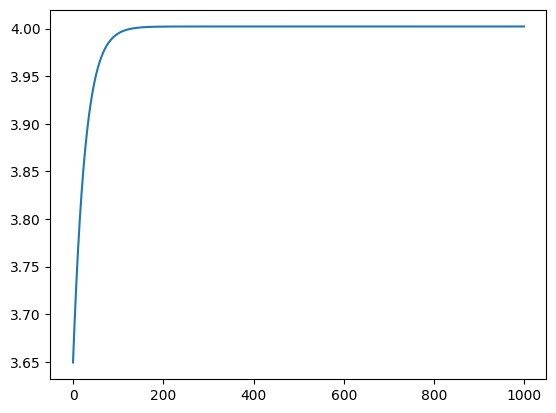

In [600]:
plt.plot(unitary_order_two_scores_array.flatten())

In [601]:
unitary_order_four_scores_array = np.array(unitary_order_four_scores)

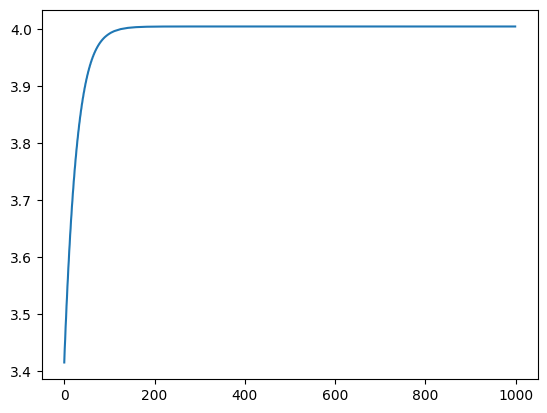

In [602]:
plt.plot(unitary_order_four_scores_array.flatten())

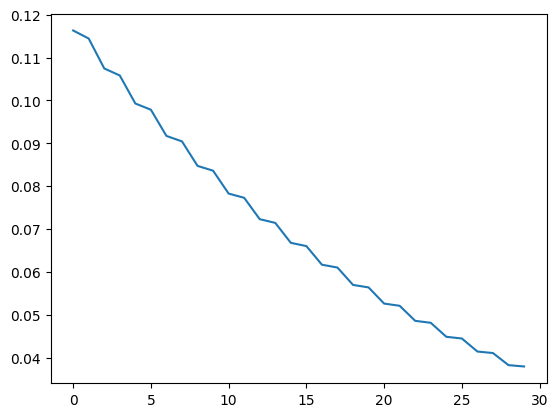

In [603]:
plt.plot(unitary_scores_array.flatten()[:30])

In [604]:
unitary_scores_array[-1]

array([1.14235837e-06, 1.14233377e-06])

In [605]:
overlap_scores_array = np.array(overlap_scores)

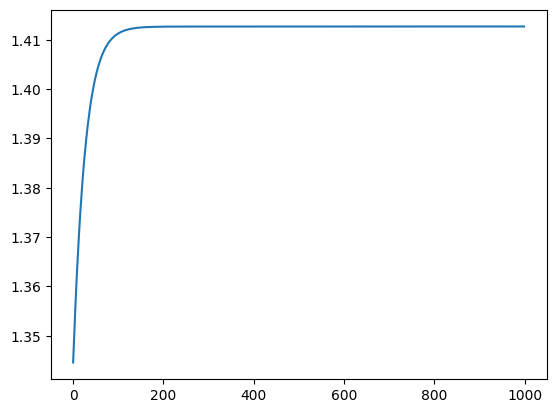

In [606]:
plt.plot(overlap_scores_array.flatten())

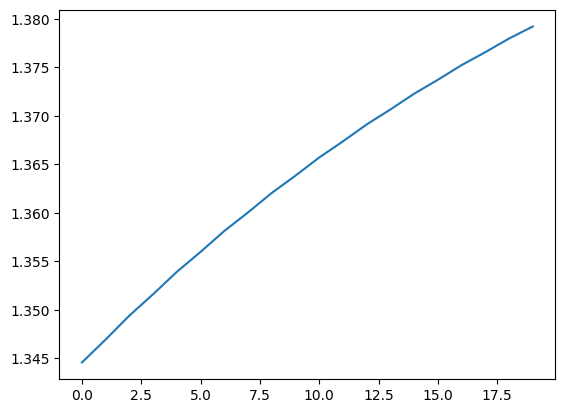

In [607]:
plt.plot(overlap_scores_array.flatten()[:20])

In [608]:
overlap_target_scores_array = np.array(overlap_target_scores)

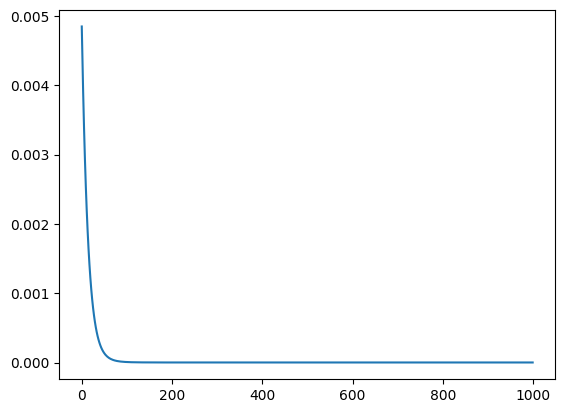

In [609]:
plt.plot(overlap_target_scores_array.flatten())

In [610]:
overlap_target_scores_array[-1]

array([2.29084765e-06, 2.29076011e-06])

In [611]:
cost_scores_array = np.array(cost_function_scores)

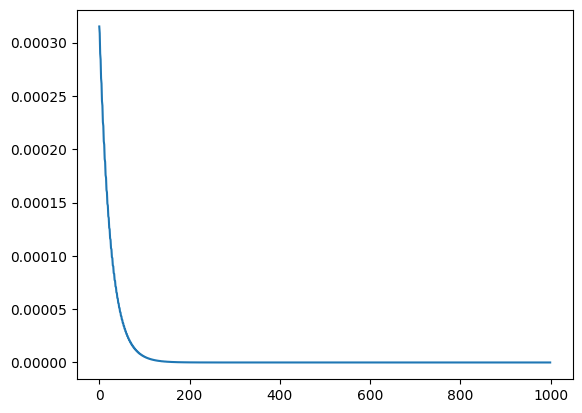

In [612]:
plt.plot(cost_scores_array.flatten())

In [613]:
cost_scores_array[-1]

array([1.43101342e-08, 1.43096350e-08])

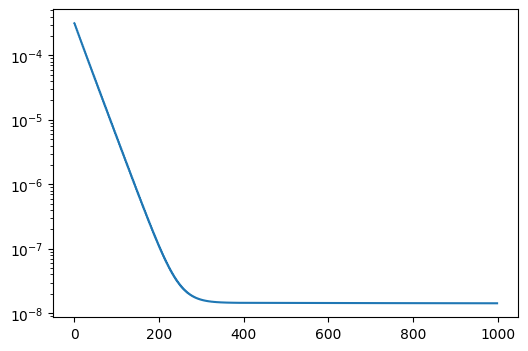

In [614]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(cost_scores_array.flatten())

ax.set_yscale('log')

In [615]:
w_tensors[0].shape

(2, 2, 1)

In [616]:
w_tensors[0].to_ndarray()[...,0]

array([[ 0.99171657+0.01701477j, -0.01533881+0.04195631j],
       [-0.01483211-0.0421381j , -0.99184959+0.00506301j]])

In [617]:
w_tensors[1].to_ndarray()[...,0]

array([[ 1.00673122+0.03047642j,  0.02215319-0.00573074j],
       [-0.0218091 -0.00692593j,  1.00690003+0.02426725j]])

Roughly what we'd expect.

## Perturbed Solution test, more sites and bond dimensions

In [618]:
num_sites = 5

In [619]:
total_dimension = 2**num_sites

In [620]:
num_iterations = 500

In [621]:
bond_dimension=4

In [622]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 4),] + [(4,4)]*(num_sites - 2) + [(4, None),]

In [623]:
X_1 = np.zeros((2, 2, bond_dimension))
X_1[...,0] = np.array([[1, 0],[0, -1]])

In [624]:
X_1.shape

(2, 2, 4)

In [625]:
sol_w_tensors = [npc.Array.from_ndarray_trivial(X_1, labels=['p', 'p*', 'vR']),]

In [626]:
for pair in virtual_dims[1:]:
    sol_w_tensors.append(get_identity_w_tensor(2, *pair))

In [627]:
sol_w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [628]:
perturbations = get_random_mpo_tensors(physical_dims, virtual_dims)

In [629]:
perturbations

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [630]:
w_tensors = [
    w1 + 0.05*w2
    for w1, w2 in zip(sol_w_tensors, perturbations)
]

In [631]:
mpo_frobenius_inner_product(w_tensors)

(38.69023356995979+0j)

In [632]:
total_dimension

32

In [633]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [634]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [635]:
b_tensors

[<npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>]

In [636]:
unitarity_learning_rate = 1e-3
overlap_learning_rate = 1e-3

In [637]:
overlap_right_tensors(w_tensors, b_tensors)

[<npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 2) labels=['vL', 'vL*']>]

In [638]:
unitary_order_two_scores = list()
unitary_order_four_scores = list()
unitary_scores = list()
overlap_scores = list()
overlap_target_scores = list()
cost_function_scores = list()

In [639]:
for _ in range(num_iterations):
    out = mpo_gradient_descent_sweep(
        w_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        total_dimension,
        np.sqrt(2),
        test_case.right_projected_symmetry_state
    )
    
    unitary_order_two_scores.append(out[0])
    unitary_order_four_scores.append(out[1])
    unitary_scores.append(out[2])
    overlap_scores.append(out[3])
    overlap_target_scores.append(out[4])
    cost_function_scores.append(out[5])

In [640]:
unitary_scores_array = np.array(unitary_scores)

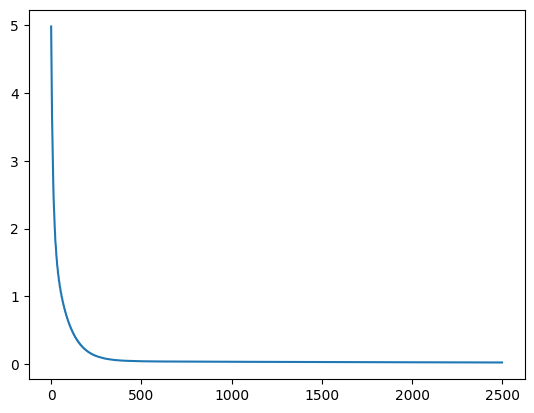

In [641]:
plt.plot(unitary_scores_array.flatten())

In [642]:
unitary_scores_array[-1]

array([0.02565037, 0.02564662, 0.02563932, 0.02563573, 0.02562882])

In [643]:
unitary_order_two_scores_array = np.array(unitary_order_two_scores)

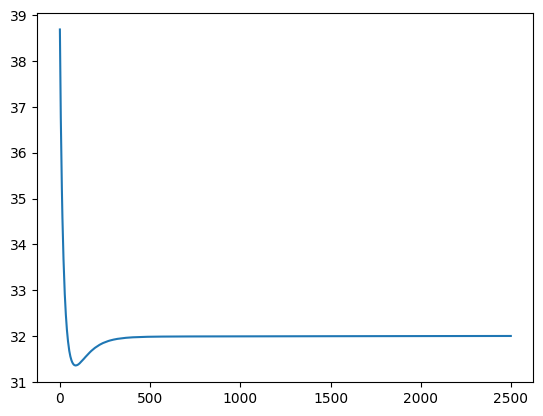

In [644]:
plt.plot(unitary_order_two_scores_array.flatten())

In [645]:
unitary_order_four_scores_array = np.array(unitary_order_four_scores)

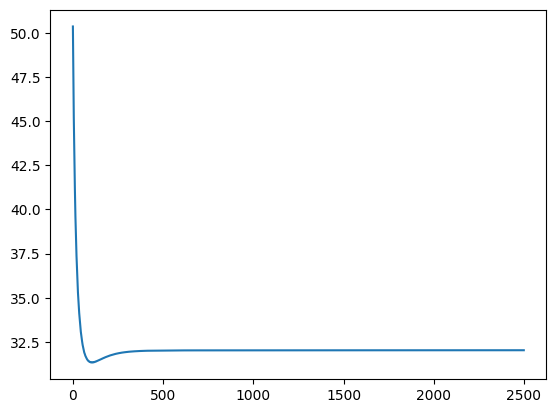

In [646]:
plt.plot(unitary_order_four_scores_array.flatten())

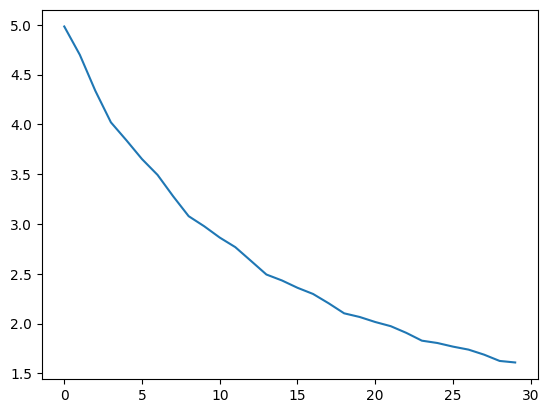

In [647]:
plt.plot(unitary_scores_array.flatten()[:30])

In [648]:
unitary_scores_array[-1]

array([0.02565037, 0.02564662, 0.02563932, 0.02563573, 0.02562882])

In [649]:
overlap_scores_array = np.array(overlap_scores)

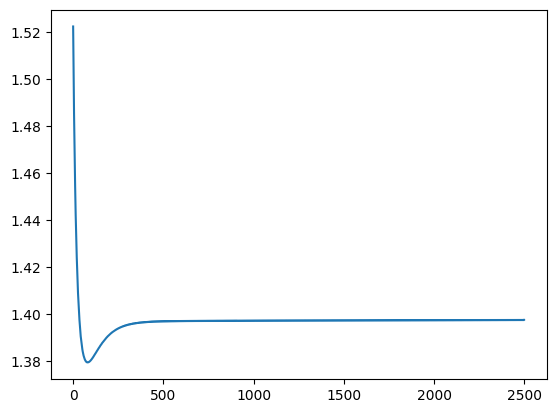

In [650]:
plt.plot(overlap_scores_array.flatten())

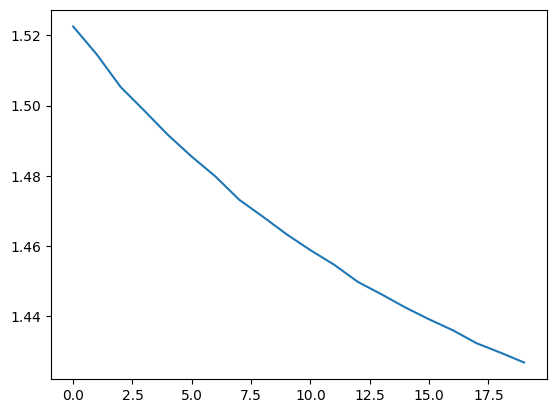

In [651]:
plt.plot(overlap_scores_array.flatten()[:20])

In [652]:
overlap_target_scores_array = np.array(overlap_target_scores)

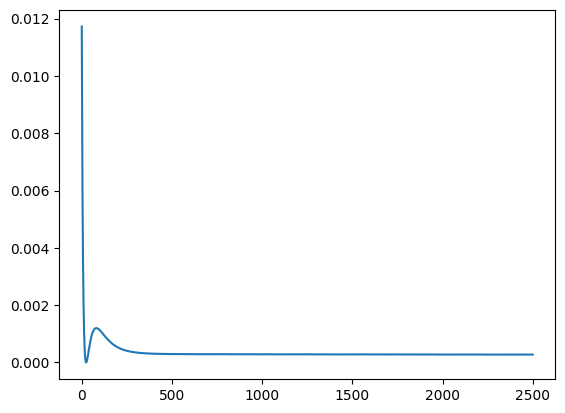

In [653]:
plt.plot(overlap_target_scores_array.flatten())

In [654]:
overlap_target_scores_array[-1]

array([0.00027475, 0.00027478, 0.00027542, 0.00027715, 0.00027471])

In [655]:
cost_scores_array = np.array(cost_function_scores)

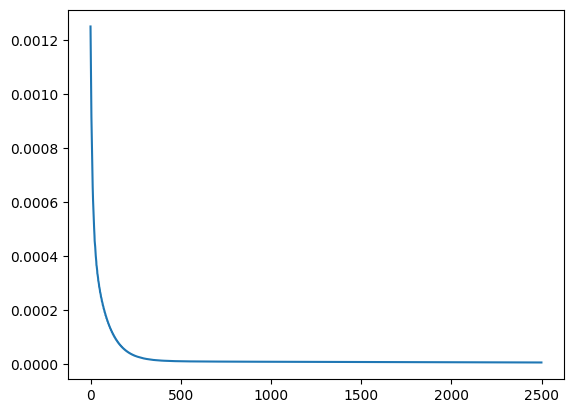

In [656]:
plt.plot(cost_scores_array.flatten())

In [657]:
cost_scores_array[-1]

array([6.54996683e-06, 6.54904574e-06, 6.54753944e-06, 6.54750771e-06,
       6.54455888e-06])

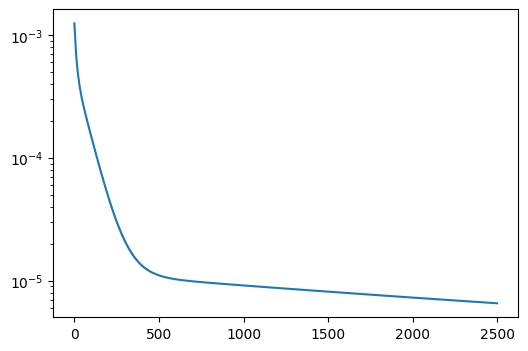

In [658]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(cost_scores_array.flatten())

ax.set_yscale('log')

## Perturbed Solution test, bigger perturbation

In [732]:
num_sites = 5

In [733]:
total_dimension = 2**num_sites

In [734]:
num_iterations = 500

In [735]:
bond_dimension=4

In [736]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 4),] + [(4,4)]*(num_sites - 2) + [(4, None),]

In [737]:
X_1 = np.zeros((2, 2, bond_dimension))
X_1[...,0] = np.array([[1, 0],[0, -1]])

In [738]:
X_1.shape

(2, 2, 4)

In [739]:
sol_w_tensors = [npc.Array.from_ndarray_trivial(X_1, labels=['p', 'p*', 'vR']),]

In [740]:
for pair in virtual_dims[1:]:
    sol_w_tensors.append(get_identity_w_tensor(2, *pair))

In [741]:
sol_w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [742]:
perturbations = get_random_mpo_tensors(physical_dims, virtual_dims)

In [743]:
perturbations

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [744]:
w_tensors = [
    w1 + 0.5*w2
    for w1, w2 in zip(sol_w_tensors, perturbations)
]

In [745]:
mpo_frobenius_inner_product(w_tensors)

(18860.656355798055-3.410605131648481e-13j)

In [746]:
total_dimension

32

In [747]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [748]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [749]:
b_tensors

[<npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>]

In [750]:
unitarity_learning_rate = 1e-8
overlap_learning_rate = 1e-8

In [751]:
overlap_right_tensors(w_tensors, b_tensors)

[<npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 2) labels=['vL', 'vL*']>]

In [752]:
unitary_order_two_scores = list()
unitary_order_four_scores = list()
unitary_scores = list()
overlap_scores = list()
overlap_target_scores = list()
cost_function_scores = list()

In [753]:
for _ in range(num_iterations):
    out = mpo_gradient_descent_sweep(
        w_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        total_dimension,
        np.sqrt(2),
        test_case.right_projected_symmetry_state
    )
    
    unitary_order_two_scores.append(out[0])
    unitary_order_four_scores.append(out[1])
    unitary_scores.append(out[2])
    overlap_scores.append(out[3])
    overlap_target_scores.append(out[4])
    cost_function_scores.append(out[5])

In [754]:
unitary_scores_array = np.array(unitary_scores)

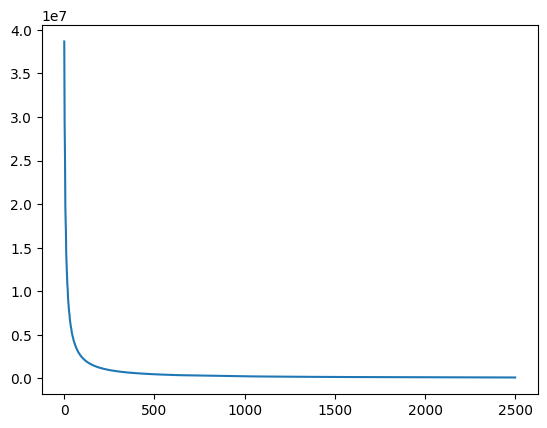

In [755]:
plt.plot(unitary_scores_array.flatten())

In [756]:
unitary_scores_array[-1]

array([74954.86492761, 74906.73037593, 74886.06572354, 74870.11900655,
       74850.71716954])

In [757]:
unitary_order_two_scores_array = np.array(unitary_order_two_scores)

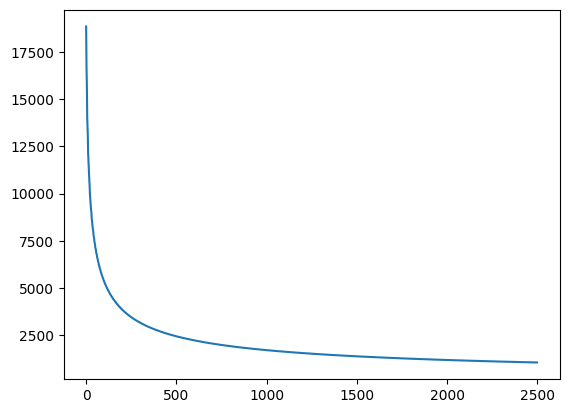

In [758]:
plt.plot(unitary_order_two_scores_array.flatten())

In [759]:
unitary_order_four_scores_array = np.array(unitary_order_four_scores)

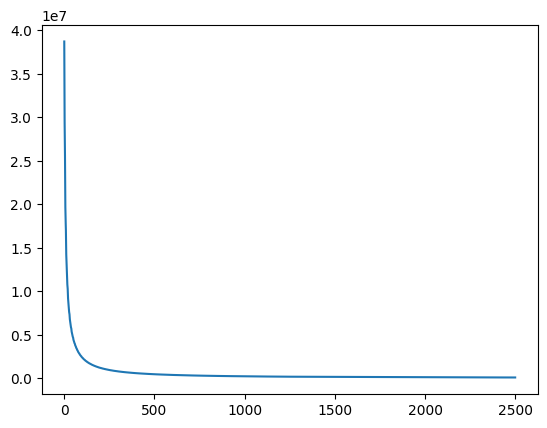

In [760]:
plt.plot(unitary_order_four_scores_array.flatten())

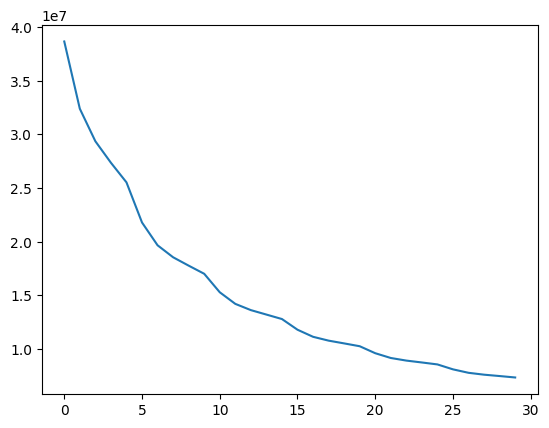

In [761]:
plt.plot(unitary_scores_array.flatten()[:30])

In [762]:
unitary_scores_array[-1]

array([74954.86492761, 74906.73037593, 74886.06572354, 74870.11900655,
       74850.71716954])

In [763]:
overlap_scores_array = np.array(overlap_scores)

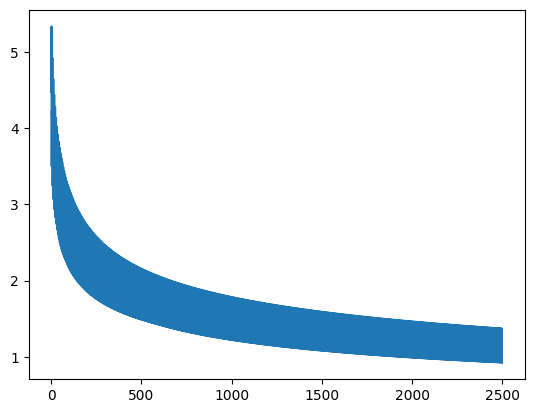

In [764]:
plt.plot(overlap_scores_array.flatten())

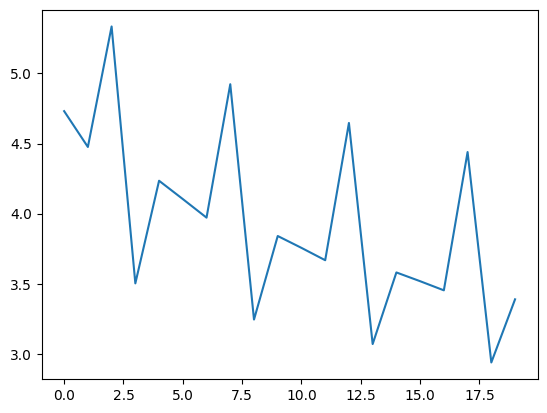

In [765]:
plt.plot(overlap_scores_array.flatten()[:20])

In [766]:
overlap_target_scores_array = np.array(overlap_target_scores)

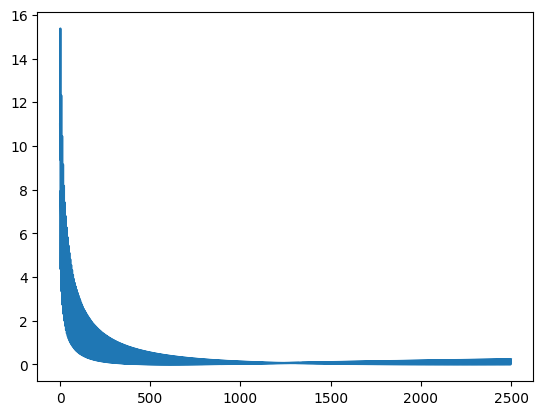

In [767]:
plt.plot(overlap_target_scores_array.flatten())

In [768]:
overlap_target_scores_array[-1]

array([0.23864067, 0.23881368, 0.00180519, 0.191255  , 0.23892738])

In [769]:
cost_scores_array = np.array(cost_function_scores)

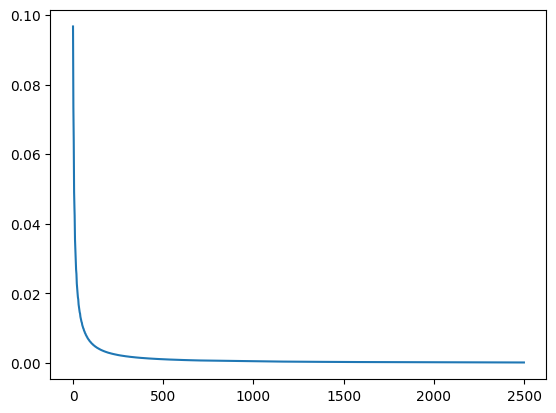

In [770]:
plt.plot(cost_scores_array.flatten())

In [771]:
cost_scores_array[-1]

array([0.00018739, 0.00018727, 0.00018722, 0.00018718, 0.00018713])

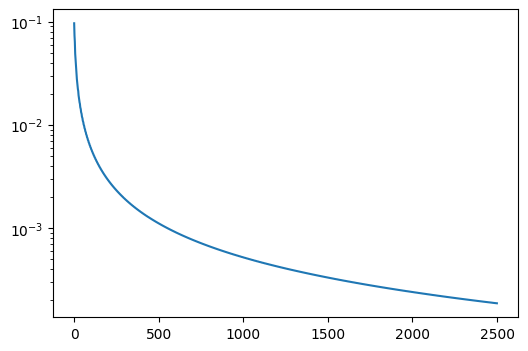

In [772]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(cost_scores_array.flatten())

ax.set_yscale('log')

As we increase noise, much more likley to get a divergence. This is an issue if random initialisation will be required, as it's not obvious how to randomly sample mpo unitaries, so would sample random arbitrary mpos instead.

## Perturbed Solution test, bigger perturbation and renormalisation.

In [511]:
num_sites = 5

In [512]:
total_dimension = 2**num_sites

In [513]:
num_iterations = 500

In [514]:
bond_dimension=4

In [515]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 4),] + [(4,4)]*(num_sites - 2) + [(4, None),]

In [516]:
X_1 = np.zeros((2, 2, bond_dimension))
X_1[...,0] = np.array([[1, 0],[0, -1]])

In [517]:
X_1.shape

(2, 2, 4)

In [518]:
sol_w_tensors = [npc.Array.from_ndarray_trivial(X_1, labels=['p', 'p*', 'vR']),]

In [519]:
for pair in virtual_dims[1:]:
    sol_w_tensors.append(get_identity_w_tensor(2, *pair))

In [520]:
sol_w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [521]:
perturbations = get_random_mpo_tensors(physical_dims, virtual_dims)

In [522]:
perturbations

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [523]:
w_tensors = [
    w1 + 0.5*w2
    for w1, w2 in zip(sol_w_tensors, perturbations)
]

In [524]:
mpo_frobenius_inner_product(w_tensors)

(8874.667484490823+0j)

In [525]:
total_dimension

32

In [526]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [527]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [528]:
b_tensors

[<npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>]

In [529]:
unitarity_learning_rate = 1e-8
overlap_learning_rate = 1e-8

In [530]:
overlap_right_tensors(w_tensors, b_tensors)

[<npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 4, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 2) labels=['vL', 'vL*']>]

In [531]:
unitary_order_two_scores = list()
unitary_order_four_scores = list()
unitary_scores = list()
overlap_scores = list()
overlap_target_scores = list()
cost_function_scores = list()

In [532]:
for _ in range(num_iterations):
    out = mpo_gradient_descent_sweep(
        w_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        total_dimension,
        np.sqrt(2),
        test_case.right_projected_symmetry_state
    )
    
    unitary_order_two_scores.append(out[0])
    unitary_order_four_scores.append(out[1])
    unitary_scores.append(out[2])
    overlap_scores.append(out[3])
    overlap_target_scores.append(out[4])
    cost_function_scores.append(out[5])

In [533]:
unitary_scores_array = np.array(unitary_scores)

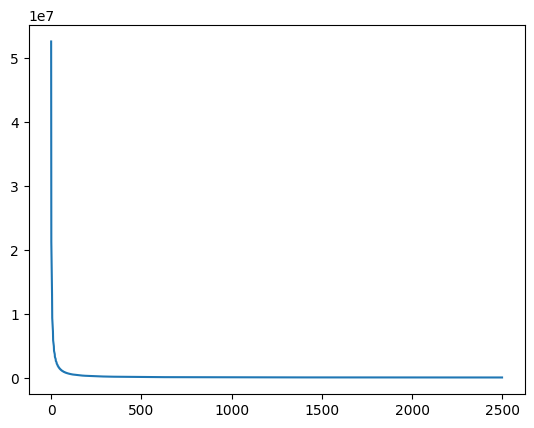

In [534]:
plt.plot(unitary_scores_array.flatten())

In [535]:
unitary_scores_array[-1]

array([10662.91364194, 10643.10545871, 10641.12552971, 10640.31424695,
       10639.09404738])

In [536]:
unitary_order_two_scores_array = np.array(unitary_order_two_scores)

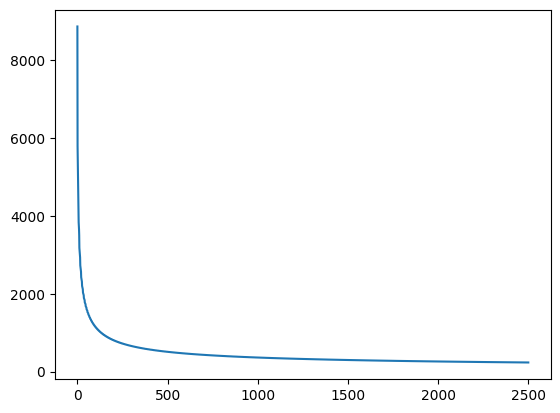

In [537]:
plt.plot(unitary_order_two_scores_array.flatten())

In [538]:
unitary_order_four_scores_array = np.array(unitary_order_four_scores)

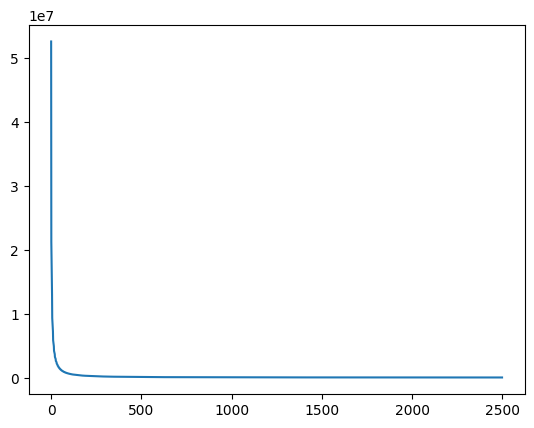

In [539]:
plt.plot(unitary_order_four_scores_array.flatten())

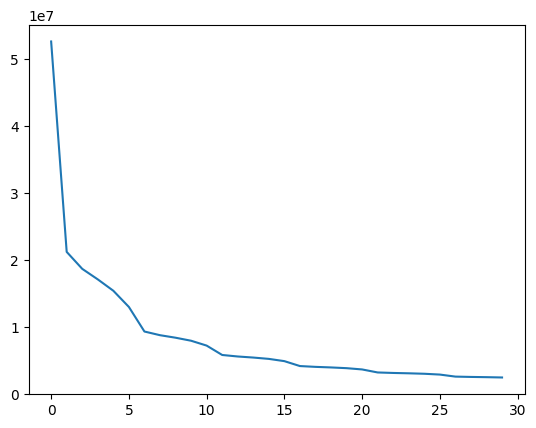

In [540]:
plt.plot(unitary_scores_array.flatten()[:30])

In [541]:
unitary_scores_array[-1]

array([10662.91364194, 10643.10545871, 10641.12552971, 10640.31424695,
       10639.09404738])

In [542]:
overlap_scores_array = np.array(overlap_scores)

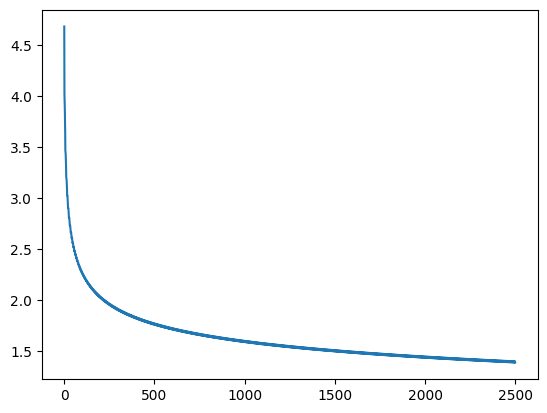

In [543]:
plt.plot(overlap_scores_array.flatten())

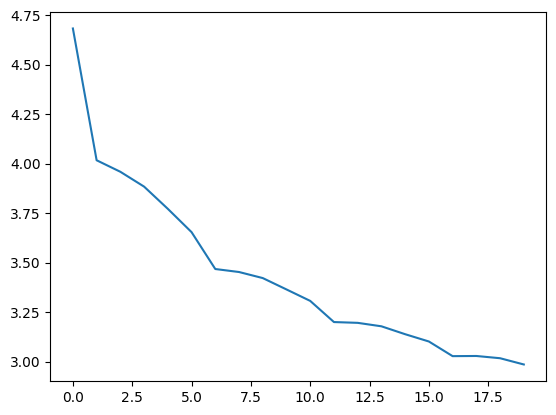

In [544]:
plt.plot(overlap_scores_array.flatten()[:20])

In [545]:
overlap_target_scores_array = np.array(overlap_target_scores)

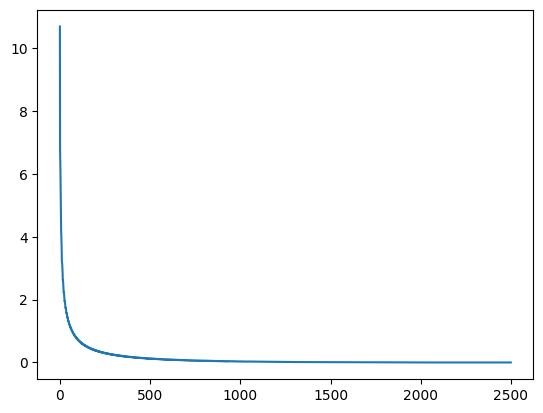

In [546]:
plt.plot(overlap_target_scores_array.flatten())

In [547]:
overlap_target_scores_array[-1]

array([0.00055456, 0.00056889, 0.00020147, 0.0001481 , 0.00057247])

In [548]:
cost_scores_array = np.array(cost_function_scores)

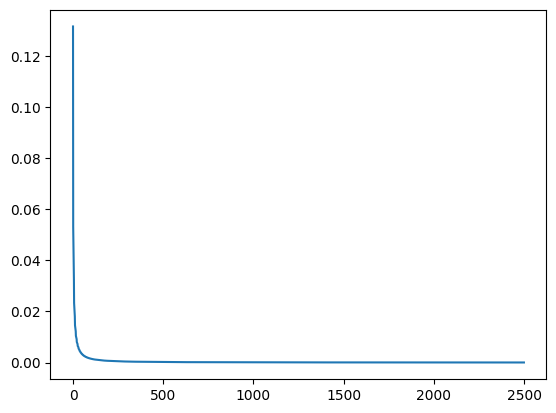

In [549]:
plt.plot(cost_scores_array.flatten())

In [550]:
cost_scores_array[-1]

array([2.66572869e-05, 2.66077665e-05, 2.66028148e-05, 2.66007864e-05,
       2.65977380e-05])

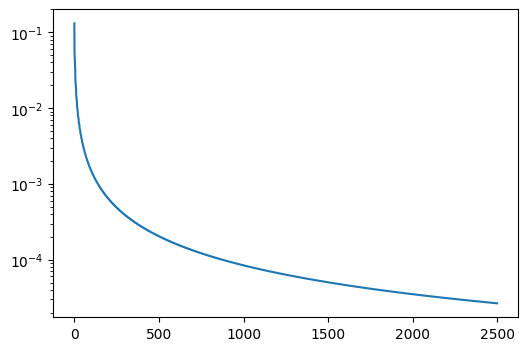

In [551]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(cost_scores_array.flatten())

ax.set_yscale('log')

As we increase noise, much more likley to get a divergence. This is an issue if random initialisation will be required, as it's not obvious how to randomly sample mpo unitaries, so would sample random arbitrary mpos instead.

## Identity test

In [104]:
num_sites = 2

In [105]:
total_dimension = 2**num_sites

In [106]:
num_iterations = 500

In [107]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 1),] + [(1, None),]

In [108]:
w_tensors = get_identity_mpo_tensors(physical_dims, virtual_dims)

In [109]:
mpo_frobenius_inner_product(w_tensors)

(4+0j)

In [110]:
total_dimension

4

In [111]:
w_tensors

[<npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 1) labels=['p', 'p*', 'vL']>]

In [112]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + num_sites)
]

In [113]:
b_tensors

[<npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(2, 2, 2) labels=['vL', 'p', 'vR']>]

In [114]:
unitarity_learning_rate = 1e-2
overlap_learning_rate = 1e-2

In [115]:
overlap_right_tensors(w_tensors, b_tensors)

[<npc.Array shape=(2, 1, 2) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(2, 2) labels=['vL', 'vL*']>]

In [116]:
unitary_order_two_scores = list()
unitary_order_four_scores = list()
unitary_scores = list()
overlap_scores = list()
overlap_target_scores = list()
cost_function_scores = list()

In [117]:
for _ in range(num_iterations):
    out = mpo_gradient_descent_sweep(
        w_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        total_dimension,
        np.sqrt(2),
        test_case.right_projected_symmetry_state
    )
    
    unitary_order_two_scores.append(out[0])
    unitary_order_four_scores.append(out[1])
    unitary_scores.append(out[2])
    overlap_scores.append(out[3])
    overlap_target_scores.append(out[4])
    cost_function_scores.append(out[5])

In [118]:
unitary_scores_array = np.array(unitary_scores)

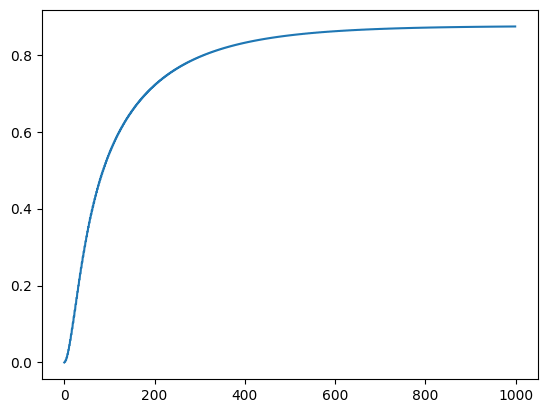

In [119]:
plt.plot(unitary_scores_array.flatten())

In [120]:
unitary_scores_array[-1]

array([0.87350277, 0.87352108])

In [121]:
unitary_order_two_scores_array = np.array(unitary_order_two_scores)

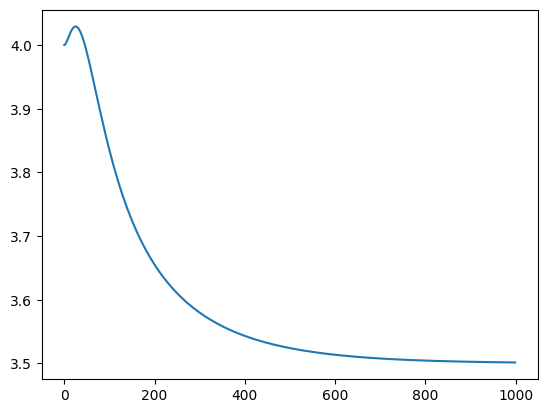

In [122]:
plt.plot(unitary_order_two_scores_array.flatten())

In [123]:
unitary_order_four_scores_array = np.array(unitary_order_four_scores)

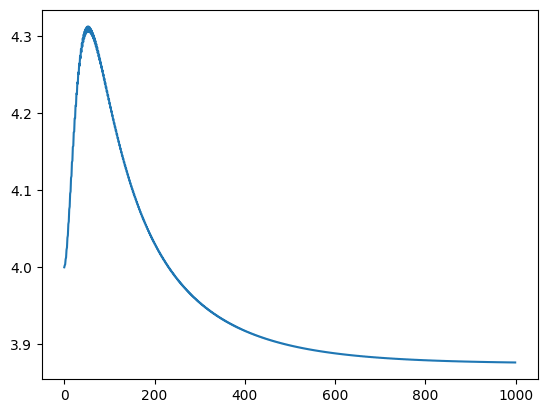

In [124]:
plt.plot(unitary_order_four_scores_array.flatten())

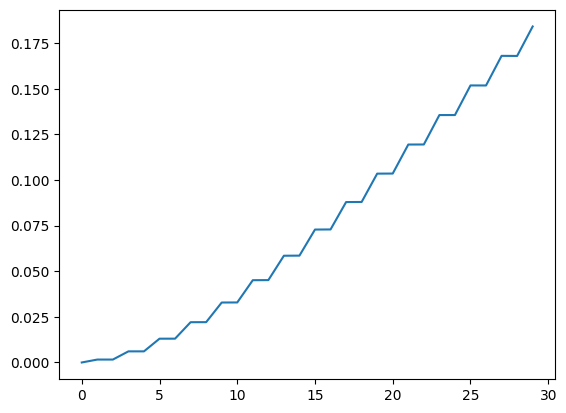

In [125]:
plt.plot(unitary_scores_array.flatten()[:30])

In [126]:
unitary_scores_array[-1]

array([0.87350277, 0.87352108])

In [127]:
overlap_scores_array = np.array(overlap_scores)

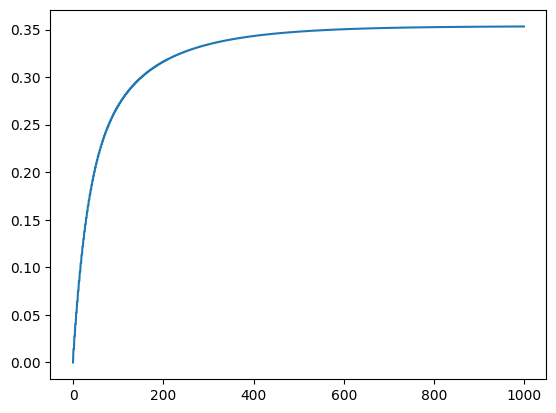

In [128]:
plt.plot(overlap_scores_array.flatten())

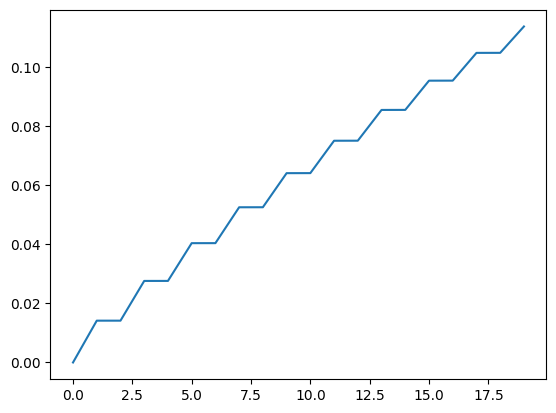

In [129]:
plt.plot(overlap_scores_array.flatten()[:20])

In [130]:
overlap_target_scores_array = np.array(overlap_target_scores)

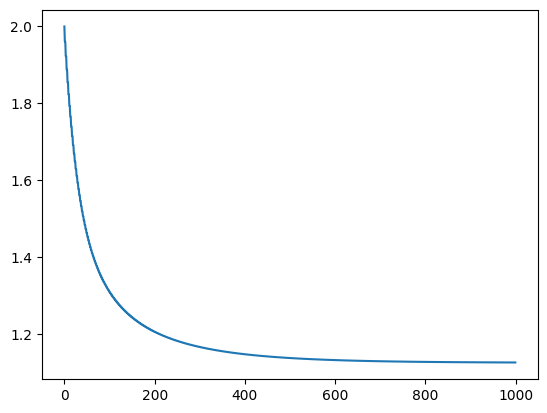

In [131]:
plt.plot(overlap_target_scores_array.flatten())

In [132]:
cost_scores_array = np.array(cost_function_scores)

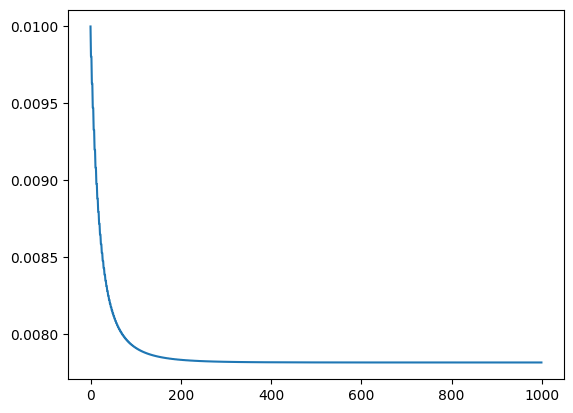

In [133]:
plt.plot(cost_scores_array.flatten())

In [135]:
cost_scores_array[-1]

array([0.0078125, 0.0078125])

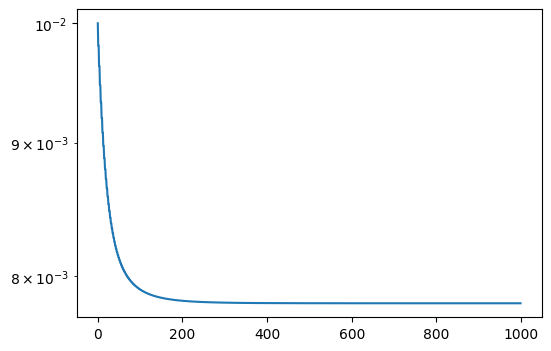

In [134]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(cost_scores_array.flatten())

ax.set_yscale('log')

## Perturbed identity test

In [80]:
num_sites = 6

In [81]:
total_dimension = 2**num_sites

In [82]:
num_iterations = 50

In [83]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 4),] + [(4,4)]*(num_sites -2 ) + [(4, None),]

In [84]:
identity_w_tensors = get_identity_mpo_tensors(physical_dims, virtual_dims)

In [85]:
mpo_frobenius_inner_product(identity_w_tensors)

(64+0j)

In [61]:
total_dimension

64

In [62]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [63]:
b_tensors = [
    test_case.psi.get_B(i)
    for i in range(test_case.right_symmetry_index + 1, test_case.right_symmetry_index + 1 + NUM_SITES)
]

In [64]:
b_tensors

[<npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>,
 <npc.Array shape=(8, 2, 8) labels=['vL', 'p', 'vR']>]

In [72]:
unitarity_learning_rate = 1e-10
overlap_learning_rate = 1e-10

In [73]:
overlap_right_tensors(w_tensors, b_tensors)

[<npc.Array shape=(8, 4, 8) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(8, 4, 8) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(8, 4, 8) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(8, 4, 8) labels=['vL', 'vLm', 'vL*']>,
 <npc.Array shape=(8, 8) labels=['vL', 'vL*']>]

In [74]:
unitary_order_two_scores = list()
unitary_order_four_scores = list()
unitary_scores = list()
overlap_scores = list()
overlap_target_scores = list()
cost_function_scores = list()

In [75]:
for _ in range(100):
    out = mpo_gradient_descent_sweep(
        w_tensors,
        b_tensors,
        unitarity_learning_rate,
        overlap_learning_rate,
        total_dimension,
        np.sqrt(2)
    )
    
    unitary_order_two_scores.append(out[0])
    unitary_order_four_scores.append(out[1])
    unitary_scores.append(out[2])
    overlap_scores.append(out[3])
    overlap_target_scores.append(out[4])
    cost_function_scores.append(out[5])

In [76]:
unitary_scores_array = np.array(unitary_scores)

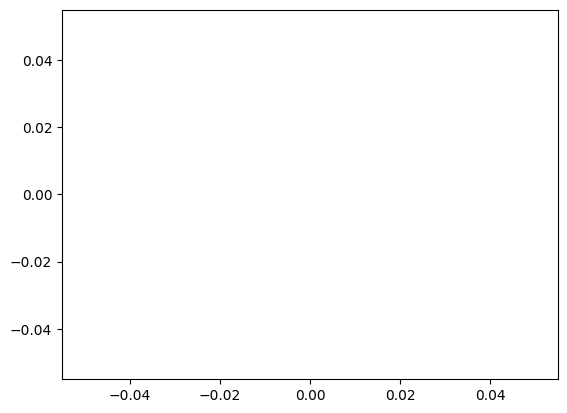

In [77]:
plt.plot(unitary_scores_array.flatten())

In [79]:
unitary_scores_array[0]

array([nan, nan, nan, nan, nan])

In [78]:
unitary_scores_array[-1]

array([nan, nan, nan, nan, nan])

# Conclusions
* Convergence is working locally, but having issues with larger perturbations.
* This is an issue because convergence to the global solution depends on the initial conditions and we do not have a reliable way to sample MPO unitaries. Therefore need a way to reliably converge to MPO unitaries from relatively far away.